In [57]:
import pandas as pd
import matplotlib.pyplot as plt
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
import numpy as np
import os
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.feature_extraction.text import TfidfVectorizer

In [43]:
def concatenate_data(imdb,amazon,yelp):
    data = []
    columns = ['sentence','label']
    path = 'sentiment labelled sentences'
    if imdb:
        data.append(pd.read_csv(os.path.join(path,'imdb_labelled.txt'), sep='\t', names=columns))
    if amazon:
        data.append(pd.read_csv(os.path.join(path,'amazon_cells_labelled.txt'), sep='\t', names = columns))
    if yelp:
        data.append(pd.read_csv(os.path.join(path,'yelp_labelled.txt'), sep='\t', names = columns))
    return pd.concat(data)
data = concatenate_data(True,True,True)
data

,sentence,label
0,"A very, very, very slow-moving, aimless movie ...",0
1,Not sure who was more lost - the flat characte...,0
2,Attempting artiness with black & white and cle...,0
3,Very little music or anything to speak of.,0
4,The best scene in the movie was when Gerardo i...,1
...,...,...
995,I think food should have flavor and texture an...,0
996,Appetite instantly gone.,0
997,Overall I was not impressed and would not go b...,0
998,"The whole experience was underwhelming, and I ...",0


In [47]:
def preprocess(text_data):
    tokenizer = RegexpTokenizer(r'\w+')
    stop_words = set(stopwords.words('english'))
    text_data['sentence'] = text_data['sentence'].apply(lambda x: tokenizer.tokenize(x.lower()))
    text_data['sentence'] = text_data['sentence'].apply(lambda x: [word for word in x if word not in stop_words])
    text_data['sentence'] = text_data['sentence'].apply(lambda x: ' '.join(x))
    X_train, X_test, y_train, y_test = train_test_split(text_data['sentence'], text_data['label'], test_size=0.2, random_state=0)
    return X_train,X_test,y_train,y_test
X_train,X_test,y_train,y_test = preprocess(data)
X_train

824                                        awful service
526                     seriously worth wasting kid time
761    around years carries highest quality anti glar...
144    telephone repair man really funny reactions nu...
735                 probably never coming back recommend
                             ...                        
15                 highly recommend one blue tooth phone
87                            construction headsets poor
905        nearly good looking amazon picture makes look
859                                   worst food service
984                                 ha long bay bit flop
Name: sentence, Length: 2198, dtype: object

In [51]:
def create_bag_of_words(X_train,X_test):
    vectorizer = TfidfVectorizer()
    X_train_tfidf = vectorizer.fit_transform(X_train)
    X_test_tfidf = vectorizer.transform(X_test)
    return X_train_tfidf,X_test_tfidf
X_train_tfidf,X_test_tfidf = create_bag_of_words(X_train,X_test)
X_train_tfidf

<2198x4347 sparse matrix of type '<class 'numpy.float64'>'
	with 13891 stored elements in Compressed Sparse Row format>

In [61]:
from sklearn.svm import SVC
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score

def cross_validate_and_train(model,X_train_tfidf,y_train):
    scoring = {'accuracy': make_scorer(accuracy_score),
           'precision': make_scorer(precision_score),
           'recall': make_scorer(recall_score),
           'f1_score': make_scorer(f1_score)}
    K_folds = 5
    cv_results = cross_validate(model, X_train_tfidf, y_train, cv=K_folds, scoring=scoring, return_estimator=True)
    for i in range(K_folds):
        print(f"Fold: {i+1}")
        print(f"Accuracy: {cv_results['test_accuracy'][i]}")
        print(f"Precision: {cv_results['test_precision'][i]}")
        print(f"Recall: {cv_results['test_recall'][i]}")
        print(f"F1 Score: {cv_results['test_f1_score'][i]}")
        print("\n")
    print("Mean Metrics")
    print(f"Mean Accuracy: {np.mean(cv_results['test_accuracy'])}")
    print(f"Mean Precision: {np.mean(cv_results['test_precision'])}")
    print(f"Mean Recall: {np.mean(cv_results['test_recall'])}")
    print(f"Mean F1 Score: {np.mean(cv_results['test_f1_score'])}")

    mean_scores = {metric: np.mean(cv_results[f'test_{metric}']) for metric in scoring.keys()}
    best_metric = max(mean_scores, key=mean_scores.get)
    best_estimator_index= np.argmax(cv_results['test_'+best_metric])
    best_estimator = cv_results['estimator'][best_estimator_index]
    print(f"Best Estimator: {best_estimator_index}")
    return best_estimator

clf = SVC(kernel='linear')
best_estimator = cross_validate_and_train(clf,X_train_tfidf,y_train)

Fold: 1
Accuracy: 0.8045454545454546
Precision: 0.8333333333333334
Recall: 0.7657657657657657
F1 Score: 0.7981220657276996


Fold: 2
Accuracy: 0.7818181818181819
Precision: 0.7837837837837838
Recall: 0.7837837837837838
F1 Score: 0.7837837837837838


Fold: 3
Accuracy: 0.8204545454545454
Precision: 0.8294930875576036
Recall: 0.8108108108108109
F1 Score: 0.8200455580865603


Fold: 4
Accuracy: 0.7835990888382688
Precision: 0.8118811881188119
Recall: 0.7420814479638009
F1 Score: 0.7754137115839245


Fold: 5
Accuracy: 0.8109339407744874
Precision: 0.8165137614678899
Recall: 0.8054298642533937
F1 Score: 0.8109339407744874


Mean Metrics
Mean Accuracy: 0.8002702422861876
Mean Precision: 0.8150010308522846
Mean Recall: 0.781574334515511
Mean F1 Score: 0.7976598119912912
Best Estimator: 0


              precision    recall  f1-score   support

           0       0.75      0.72      0.74       272
           1       0.74      0.77      0.75       278

    accuracy                           0.75       550
   macro avg       0.75      0.75      0.75       550
weighted avg       0.75      0.75      0.75       550



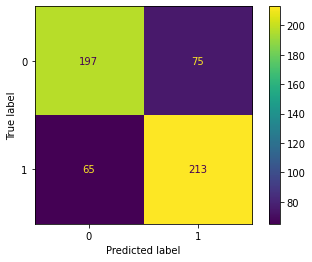

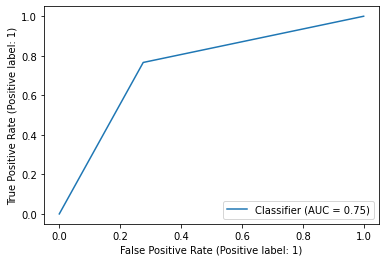

In [65]:
from sklearn.metrics import confusion_matrix, classification_report,ConfusionMatrixDisplay, roc_curve, roc_auc_score, RocCurveDisplay
def test_model(model,X_test_tfidf,y_test):
    y_pred = model.predict(X_test_tfidf)
    print(classification_report(y_test, y_pred))
    cm = confusion_matrix(y_test, y_pred)
    ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_).plot()
    RocCurveDisplay.from_predictions(y_test, y_pred)
    plt.show()
test_model(best_estimator,X_test_tfidf,y_test)